# Imports

In [1]:
import torch
import torch.nn as nn
from models import EncoderRNN, LuongAttnDecoderRNN, GreedySearchDecoder, BeamSearchDecoder
from vocabulary import Voc
from utils import evaluate, normalizeString, calculate_distinct_n_grams, loadPreparedData, calculate_f1
import matplotlib.pyplot as plt
import numpy as np
from torchtext.data.metrics import bleu_score

# Load Model

In [2]:
# Specify the path to the checkpoint file
checkpoint_path = 'checkpoints/4000_checkpoint.tar'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Access the information from the checkpoint
iteration = checkpoint['iteration']
encoder_state_dict = checkpoint['en']
decoder_state_dict = checkpoint['de']
encoder_optimizer_state_dict = checkpoint['en_opt']
decoder_optimizer_state_dict = checkpoint['de_opt']
train_loss = checkpoint['train loss']
val_loss = checkpoint['val loss']
train_perplexity = checkpoint['train perplexity']
val_perplexity = checkpoint['val perplexity']
voc_dict = checkpoint['voc_dict']

In [3]:
# Reconstruct vocabulary
voc = Voc(voc_dict['name'])
voc.__dict__ = voc_dict

In [4]:
# Reconstruct models
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1

encoder = EncoderRNN(hidden_size=hidden_size, 
                     embedding=nn.Embedding(num_embeddings=voc.num_words, embedding_dim=hidden_size),
                     n_layers=encoder_n_layers, 
                     dropout=dropout)

decoder = LuongAttnDecoderRNN(attn_model='dot', 
                              embedding=nn.Embedding(num_embeddings=voc.num_words, embedding_dim=hidden_size), 
                              hidden_size=hidden_size, 
                              output_size=voc.num_words, 
                              n_layers=decoder_n_layers, 
                              dropout=dropout)

# Load state into encoder and decoder
encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

# Set layers to eval mode
encoder.eval()
decoder.eval()

LuongAttnDecoderRNN(
  (embedding): Embedding(6131, 500)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=6131, bias=True)
  (attn): Attn()
)

# Loss & Perplexity

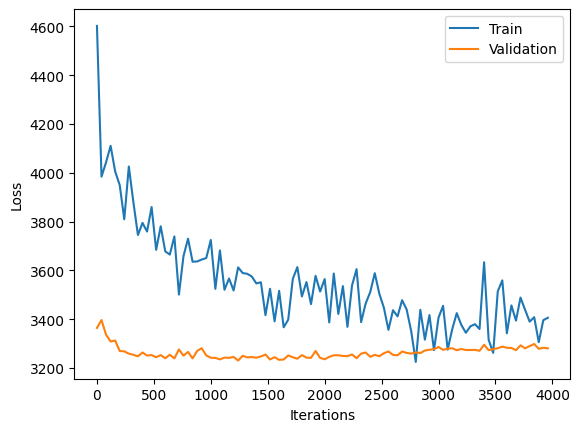

In [5]:
iters = [i*40 for i in range(len(train_loss))]

plt.plot(iters, train_loss, label='Train')
plt.plot(iters, [i*600 for i in val_loss], label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

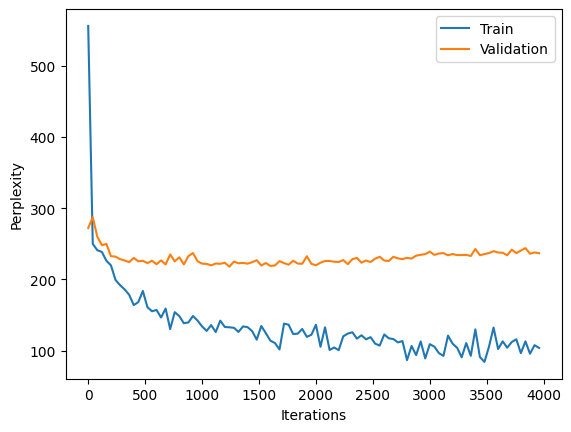

In [6]:
plt.plot(iters, train_perplexity, label='Train')
plt.plot(iters, val_perplexity, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

# Example Inputs

In [7]:
# Input utterances generated by chat-GPT
input_utts = [
    "Why do I always get stuck in the middle of everyone's problems ?",
    "Imagine if we could solve disputes with a dance-off instead of arguments .",
    "Do you think a penguin could be a good pet in the city ?",
    "I accidentally sent a love confession to the group chat , help !",
    "What's the weirdest thing you've ever done to impress a crush ?",
    "Have you ever walked into a room and forgotten why you're there ?",
    "Why is it that every time I try to cook , the fire alarm goes off ?",
    "I just tried talking to my crush , and I could only speak in movie quotes .",
    "If you had to choose , would you rather give up coffee or pizza ?",
    "Is it okay to wear socks with sandals if nobody's going to see ?",
    "Why do I feel like my laundry multiplies every time I blink ?",
    "Do you believe in love at first sight , or should I walk by again ?",
    "What's your take on eating pizza with a fork and knife ?",
    "Is talking to plants really supposed to help them grow ?",
    "I dreamed I was a muffin ; what do you think it means ?",
    "Why is it that I can never find my keys when I'm late ?",
    "Do you think ducks have best friends ?",
    "I just found out I've been using a word wrong my entire life .",
    "Would you rather fight one horse-sized duck or a hundred duck-sized horses ?",
    "What's the protocol for accidentally waving at someone who wasn't waving at you ?",
    "Do you ever practice conversations in your head before having them ?",
    "How many days in a row can you wear the same pair of jeans ?",
    "Why does my phone always die at the worst possible times ?",
    "Have you ever sent a text about someone to that person by accident ?",
    "What's the most embarrassing song you love ?",
    "Why do I feel like I need a vacation from my vacation ?",
    "Do you think it's possible to be too good at thumb wrestling ?",
    "What would you do if you found out you had a secret twin ?",
    "Why are my awkward moments always witnessed by the most people ?",
    "If you could have any superpower , but it had to be really mundane , what would it be ?",
    "What's the silliest reason you've ever had a falling out with someone ?",
    "Have you ever tried to bake something and it turned into a disaster ?",
    "Is double-dipping really that bad ?",
    "What's the strangest coincidence you've ever experienced ?",
    "Have you ever laughed so hard , no sound came out , and you just sat there clapping like a seal ?",
    "Why is it that when you're trying not to laugh , everything becomes ten times funnier ?",
    "Do you think if we didn't have thumbs , we'd still be the dominant species ?",
    "What's the best way to subtly escape a boring conversation ?",
    "Have you ever had a dream where you showed up to work in your pajamas ?",
    "Why do I always crave snacks right after I decide to start eating healthier ?",
    "Do you ever wonder what your pet names you in their head ?",
    "What's the worst haircut you've ever had ?",
    "Have you ever accidentally memorized a song you hate ?",
    "Why is deciding what to have for dinner the hardest decision of the day ?",
    "Is it really a road trip if you don't sing along to the radio at the top of your lungs ?",
    "Have you ever tried to make a recipe you saw in a cartoon ?",
    "What's the funniest thing you've ever seen a stranger do ?",
    "Do you think time travel will ever be possible , and if so , what time would you visit ?",
    "Why is it that every time I try to be cool , I end up doing something awkward ?",
    "If animals could talk , which species do you think would be the most annoying ?"
]


In [8]:
# Load validation pairs
val_pairs = loadPreparedData("validation_pairs.txt")
val_pairs[:5]

[["hi i'm rachel is my sweater too tight ? no ? oh i'd better wash it and shrink it !",
  "i'm monica i don't get phone messages from interesting people . ever !"],
 ['oh you you mean your earrings ?', "what'd i say ?"],
 ["uhh yeah i think i'm going to take off too .",
  "no ! you guys can't leave yet ! you have to stay we we got the whole big thing planned !"],
 ['no . no !', 'hello rachel .'],
 ['yes ! your honor ?',
  "we're now in the ceremony monica is about to say i do when her drunk uncle starts yelling . what do you do ? go !"]]

# Greedy Search Decoder

## Basic Test

In [9]:
# Create searcher instance
searcher = GreedySearchDecoder(encoder, decoder)

# Input sentence
input_sentence = "hello"

# Evaluate sentence
output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
output_sentence = ' '.join(output_words)

print('Input:', input_sentence)
print('Output:', output_sentence)

Input: hello
Output: hey !


In [10]:
input_utts_normalized = [normalizeString(utt) for utt in input_utts]
input_utts_filtered = [input_utt for input_utt in input_utts_normalized if all(word in voc.word2index.keys() for word in input_utt.split())]
input_utts_filtered[:5]

["why do i always get stuck in the middle of everyone's problems ?",
 'do you think a penguin could be a good pet in the city ?',
 "what's the weirdest thing you've ever done to impress a crush ?",
 "have you ever walked into a room and forgotten why you're there ?",
 "what's your take on eating pizza with a fork and knife ?"]

In [11]:
val_inputs = [pair[0] for pair in val_pairs]
val_inputs[:5]

["hi i'm rachel is my sweater too tight ? no ? oh i'd better wash it and shrink it !",
 'oh you you mean your earrings ?',
 "uhh yeah i think i'm going to take off too .",
 'no . no !',
 'yes ! your honor ?']

## Distinct n-grams

In [12]:
searcher = GreedySearchDecoder(encoder, decoder)
attempts = 10
outputs = [[] for _ in range(len(val_inputs))]

for idx, input_utt in enumerate(val_inputs):
    print(f"Generating responses for input utterance {idx + 1} / {len(val_inputs)}...")
    for _ in range(attempts):
        output_words = evaluate(encoder, decoder, searcher, voc, input_utt)
        output_utt = ' '.join(output_words)
        outputs[idx].append(output_utt)

Generating responses for input utterance 1 / 3873...
Generating responses for input utterance 2 / 3873...
Generating responses for input utterance 3 / 3873...
Generating responses for input utterance 4 / 3873...
Generating responses for input utterance 5 / 3873...
Generating responses for input utterance 6 / 3873...
Generating responses for input utterance 7 / 3873...
Generating responses for input utterance 8 / 3873...
Generating responses for input utterance 9 / 3873...
Generating responses for input utterance 10 / 3873...
Generating responses for input utterance 11 / 3873...
Generating responses for input utterance 12 / 3873...
Generating responses for input utterance 13 / 3873...
Generating responses for input utterance 14 / 3873...
Generating responses for input utterance 15 / 3873...
Generating responses for input utterance 16 / 3873...
Generating responses for input utterance 17 / 3873...
Generating responses for input utterance 18 / 3873...
Generating responses for input uttera

In [13]:
distinct_1 = [calculate_distinct_n_grams(outputs[i], n=1) for i in range(len(input_utts_filtered))]
distinct_2 = [calculate_distinct_n_grams(outputs[i], n=2) for i in range(len(input_utts_filtered))]

print(f"Distinct-1: {np.mean(distinct_1):.4f}")
print(f"Distinct-2: {np.mean(distinct_2):.4f}")

Distinct-1: 0.0930
Distinct-2: 0.0970


## BLEU Score

In [14]:
# Calculate BLEU scores for each input
bleu_scores = [bleu_score([outputs[i]], [[val_pairs[i][1]]]) for i in range(len(val_inputs))]
print(f"BLEU score: {np.mean(bleu_scores):.4f}")

BLEU score: 0.0000


## F1 Score

In [15]:
# Calculate F1 scores for each input
f1_scores = [calculate_f1(outputs[i][0], val_pairs[i][1]) for i in range(len(val_inputs))]
print(f"F1 score: {np.mean(f1_scores):.4f}")

F1 score: 0.0687


# Beam Search Decoder

## Basic Test

In [16]:
# Create searcher instance
beam_width = 10
searcher = BeamSearchDecoder(encoder, decoder, beam_width)

# Input sentence
input_sentence = "hello"

# Evaluate sentence
output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
output_sentence = ' '.join(output_words)

print('Input:', input_sentence)
print('Output:', output_sentence)

Input: hello
Output: hi .


## Distinct n-grams

In [17]:
searcher = BeamSearchDecoder(encoder, decoder, beam_width)
attempts = 50
outputs = [[] for _ in range(len(val_inputs))]

for idx, input_utt in enumerate(val_inputs):
    print(f"Generating responses for input utterance {idx + 1} / {len(val_inputs)}...")
    for _ in range(attempts):
        output_words = evaluate(encoder, decoder, searcher, voc, input_utt)
        output_utt = ' '.join(output_words)
        outputs[idx].append(output_utt)

Generating responses for input utterance 1 / 3873...


Generating responses for input utterance 2 / 3873...
Generating responses for input utterance 3 / 3873...
Generating responses for input utterance 4 / 3873...
Generating responses for input utterance 5 / 3873...
Generating responses for input utterance 6 / 3873...
Generating responses for input utterance 7 / 3873...
Generating responses for input utterance 8 / 3873...
Generating responses for input utterance 9 / 3873...
Generating responses for input utterance 10 / 3873...
Generating responses for input utterance 11 / 3873...
Generating responses for input utterance 12 / 3873...
Generating responses for input utterance 13 / 3873...
Generating responses for input utterance 14 / 3873...
Generating responses for input utterance 15 / 3873...
Generating responses for input utterance 16 / 3873...
Generating responses for input utterance 17 / 3873...
Generating responses for input utterance 18 / 3873...
Generating responses for input utterance 19 / 3873...
Generating responses for input utter

In [ ]:
distinct_1 = [calculate_distinct_n_grams(outputs[i], n=1) for i in range(len(input_utts_filtered))]
distinct_2 = [calculate_distinct_n_grams(outputs[i], n=2) for i in range(len(input_utts_filtered))]

print(f"Distinct-1: {np.mean(distinct_1):.4f}")
print(f"Distinct-2: {np.mean(distinct_2):.4f}")

Distinct-1: 0.0197
Distinct-2: 0.0200


## BLEU Score

In [ ]:
# Calculate BLEU scores for each input
bleu_scores = [bleu_score([outputs[i]], [[val_pairs[i][1]]]) for i in range(len(val_inputs))]
print(f"BLEU score: {np.mean(bleu_scores):.4f}")

BLEU score: 0.0000


## F1 Score

In [ ]:
# Calculate F1 scores for each input
f1_scores = [calculate_f1(outputs[i][0], val_pairs[i][1]) for i in range(len(val_inputs))]
print(f"F1 score: {np.mean(f1_scores):.4f}")

F1 score: 0.0687
